## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#unzip the dataset
#!unzip "/content/gdrive/MyDrive/SkinCancerDataset.zip" > /dev/null

#### Importing all the important libraries

In [2]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import load_img

#### Importing Skin Cancer Data

In [3]:
import os
print(os.getcwd())

C:\Users\Ruchita parmar\streamlitapp\melonama_cancer


In [12]:
# Defining the path for train and test images

#data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
#data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

#root_path = '/content/gdrive/MyDrive/app/skin_cancer'
root_path = 'C:/Users/Ruchita parmar/others/Skin cancer ISIC The International Skin Imaging Collaboration/'

data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [11]:
root_path = 'H:/machine learning backup AI ML/Skin cancer ISIC The International Skin Imaging Collaboration/'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [12]:
data_dir_train

WindowsPath('H:/machine learning backup AI ML/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [6]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


#### This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

Total number of images mentioned on the upgrad 2357 matches with the above count 2239+118. So we are good

#### Use 80% of the images for training, and 20% for validation.

In [15]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [16]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [17]:
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.


# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


**Data Visualization**

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Found 2239 files belonging to 9 classes.


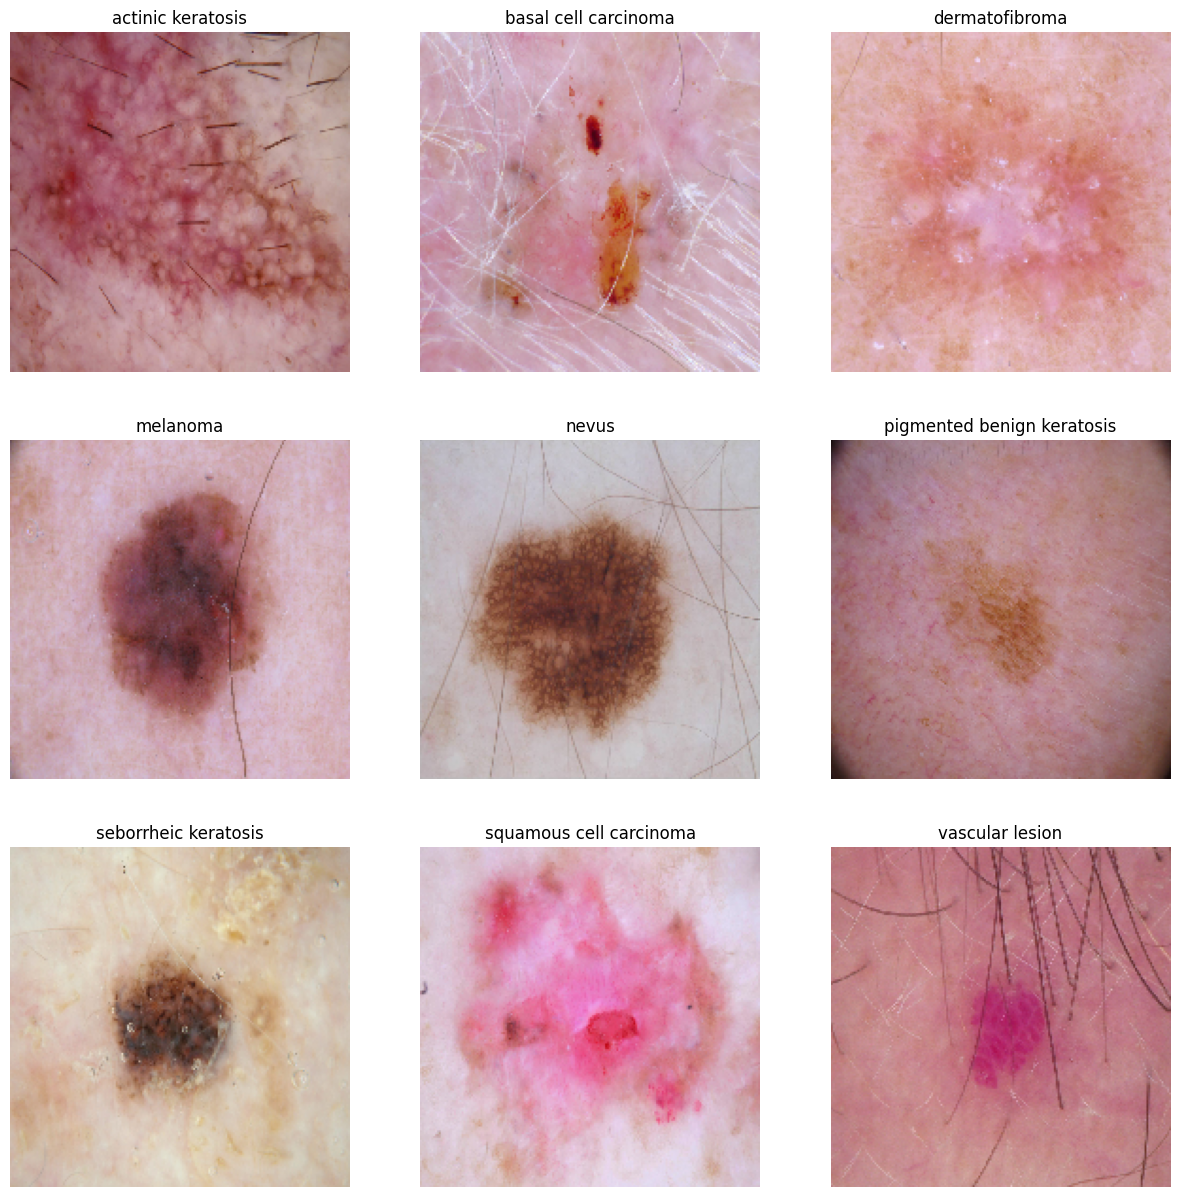

In [18]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [19]:


#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



#### Model 1 Create the model
Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [28]:


#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

# Images rescaled/ Rescaling layer
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(8,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 87, 87, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 43, 43, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 41, 41, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 20, 20, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 20, 20, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 8)                   │          51,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,377 (220.22 KB)

 Trainable params: 56,377 (220.22 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # vizualizing the model
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


#### Compile the model + Train the model

Choose an appropirate optimiser and loss function for model training

In [30]:

#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)




# Train the model
epochs = 20
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])






Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1595 - loss: 2.1945
Epoch 1: val_accuracy improved from -inf to 0.13043, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 172ms/step - accuracy: 0.1598 - loss: 2.1944 - val_accuracy: 0.1304 - val_loss: 2.1966
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1858 - loss: 2.1659
Epoch 2: val_accuracy improved from 0.13043 to 0.17391, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.1858 - loss: 2.1658 - val_accuracy: 0.1739 - val_loss: 2.2991
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2049 - loss: 2.1267
Epoch 3: val_accuracy did not improve from 0.17391
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.2050 - loss: 2.1264 - val_accuracy: 0.1304 - val_loss: 2.3982
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2070 - loss: 2.0600
Epoch 4: val_accuracy did not improve from 0.17391
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/s

# Model 2 transfer learning 

In [42]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [32]:
from keras.applications import mobilenet

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2 # Import MobileNetV2

# Assuming 'class_names' is defined and holds the list of your class names
# For demonstration, let's define a dummy class_names if it's not present:
# class_names = ['class_a', 'class_b', 'class_c'] # Replace with your actual class names

# 1. Instantiate the MobileNetV2 base model with pre-trained ImageNet weights
#    include_top=False removes the classifier head of MobileNetV2,
#    so we can add our own custom classifier.
IMG_HEIGHT = 180
IMG_WIDTH = 180
CHANNELS = 3

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
    include_top=False,
    weights='imagenet'
)

# 2. Freeze the base model
#    This prevents the pre-trained weights from being updated during the initial training.
#    This is a common practice in transfer learning to leverage learned features
#    without destroying them. You can unfreeze later for fine-tuning.
base_model.trainable = False

# CNN Model Architecture with MobileNetV2 Transfer Learning

model = Sequential()

# Images rescaled/ Rescaling layer (MobileNetV2 expects input in [-1, 1] typically,
# but your current Rescaling to [0, 1] will work.
# If you want exact MobileNetV2 preprocessing, you'd use tf.keras.applications.mobilenet_v2.preprocess_input
# after Rescaling. For simplicity, we'll keep your Rescaling layer as is.)
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))


# Add the MobileNetV2 base model
model.add(base_model)

# Add a GlobalAveragePooling2D layer
# This layer effectively flattens the output of the base_model (which is a 3D tensor)
# into a 1D tensor by taking the average of each feature map.
# It's commonly used after convolutional bases for classification tasks
# because it greatly reduces the number of parameters compared to Flatten.
model.add(layers.GlobalAveragePooling2D())

# Dropout layer (often helpful after pooling or flattening)
model.add(layers.Dropout(0.5)) # Kept your 0.5 dropout

# Dense Layer (can be used to learn higher-level representations from the pooled features)
# You can adjust the number of units (e.g., 128, 64, 32) based on your dataset complexity.
# Start with a moderate number like 128 or 64.
model.add(layers.Dense(128, activation='relu')) # Changed from 8, 8 is likely too small for a good classifier

# Another Dropout layer
model.add(layers.Dropout(0.25)) # Adjusted to 0.25, you had 0.5 before this dense layer.

# Output Dense Layer with softmax activation function.
# The number of units here MUST match the number of your classes.
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

# --- Explanation of changes and further considerations ---

# To confirm the base model is frozen:
print(f"Is base_model trainable? {base_model.trainable}")

# You'll typically compile the model after this:
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy', # Use categorical_crossentropy for one-hot encoded labels
#               metrics=['accuracy'])

# And then train:
# history = model.fit(train_ds, validation_data=val_ds, epochs=10) # Adjust epochs as needed

# Fine-tuning (Optional, but recommended for better performance):
# After training for a few epochs with the base model frozen, you can unfreeze it
# and train with a very low learning rate to fine-tune the pre-trained weights
# to your specific dataset.

# print("Unfreezing base model for fine-tuning...")
# base_model.trainable = True
# # It's important to recompile the model after unfreezing layers for the changes to take effect
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Use a very low learning rate
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])
# # Continue training for more epochs
# history_fine_tune = model.fit(train_ds, validation_data=val_ds, epochs=your_new_epochs_count)

C:\Users\Ruchita parmar\AppData\Local\Temp\ipykernel_15420\1923180550.py:17: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Is base_model trainable? False


In [51]:
import datetime
curr_dt_time = datetime.datetime.now()
model_name = 'model_init_exp_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{accuracy:.5f}-{val_loss:.5f}-{val_accuracy:.5f}.keras'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [52]:

#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)




# Train the model
epochs = 30
#epochs=1
#history2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=callbacks_list)

history2=model.fit(train_ds, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_ds, 
                     class_weight=None, initial_epoch=0)



Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.3948 - loss: 1.6914
Epoch 1: saving model to model_init_exp_2_2025-06-1721_01_35.947466/model-00001-1.67542-0.39900-1.98108-0.30435.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 453ms/step - accuracy: 0.3949 - loss: 1.6912 - val_accuracy: 0.3043 - val_loss: 1.9811 - learning_rate: 0.0010
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.3976 - loss: 1.6211
Epoch 2: saving model to model_init_exp_2_2025-06-1721_01_35.947466/model-00002-1.59206-0.41685-1.96224-0.30435.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.3979 - loss: 1.6206 - val_accuracy: 0.3043 - val_loss: 1.9622 - learning_rate: 0.0010
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.4380 - loss: 1.5211
Epoch 3: saving model to model_init_exp_2_2025-06-1721_01_35.947466/model-00003-1.49303-0.45982-1.79403-0.34783.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 391ms/step - accuracy: 0.4384 - loss: 1.5206 - val_accuracy: 0.3478 - val

# Model 3 with handling class imbalance 

In [54]:
#pip install scikit-learn

In [62]:
from tensorflow.keras.utils import register_keras_serializable

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import datetime
import os
import numpy as np # Still needed for dataset operations, but not for class_weight calculation
import keras
from keras import saving

# --- Configuration ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
CHANNELS = 3

# Define your melanoma classes (ensure this matches the order inferred by image_dataset_from_directory)
# This list is used for defining the output layer size and for clarity.
MELANOMA_LABELS = [
    "Actinic keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Nevus",
    "Pigmented benign keratosis",
    "Seborrheic keratosis",
    "Squamous cell carcinoma",
    "Vascular lesion"
]
num_classes = len(MELANOMA_LABELS)

# --- Data Loading ---
# Assuming you have `data_dir_train` defined.
# This part of the code assumes your `data_dir_train` and `data_dir_val` are correctly set up.
# For example:
# data_dir_train = 'path/to/your/train/data_directory' # e.g., 'C:/Users/Ruchita parmar/Desktop/melanoma_data/train'

print("Loading datasets...")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical', # Labels will be one-hot encoded
    seed=123,
    subset="training",
    validation_split=0.2 # Assuming data_dir_train contains both train and val splits
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, # Still using data_dir_train as the source for validation_split
    batch_size=32,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    seed=123,
    subset="validation",
    validation_split=0.2
)

# Get class names after creating the dataset, as it infers from folder names
class_names = train_ds.class_names
print("Class Names (alphabetical by folder name):", class_names)
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")


# Optimize dataset for performance (recommended for large datasets)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- Model Architecture ---
# 1. Instantiate the MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
    include_top=False, # Exclude the top classification layer
    weights='imagenet' # Use pre-trained weights from ImageNet
)

# 2. Freeze the base model for the initial training phase
base_model.trainable = False
print(f"Base MobileNetV2 model initially trainable: {base_model.trainable}")



# Define a custom Lambda layer function and register it for serialization
@saving.register_keras_serializable(package="CustomLayers") # <--- Use 'saving' directly
def mobilenet_v2_custom_preprocess_input(inputs):
    """
    A custom Lambda layer equivalent for MobileNetV2's preprocess_input.
    This allows the model to be saved and loaded properly.
    """
    return tf.keras.applications.mobilenet_v2.preprocess_input(inputs)



# Build the Sequential model
model = Sequential()

# Add the MobileNetV2 preprocessing layer. This layer handles scaling from [0, 255] to [-1, 1].
# model.add(tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input,
#                                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
model.add(tf.keras.layers.Lambda(mobilenet_v2_custom_preprocess_input, # <-- Use the registered function here
                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

# Add the frozen MobileNetV2 base model
model.add(base_model)

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
model.add(layers.GlobalAveragePooling2D())

# Dropout layer for regularization
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Dense Layer for the classification head
model.add(layers.Dense(128, activation='relu'))

# Another Dropout layer
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Output Dense Layer with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax')) # num_classes based on your labels

model.summary()


# --- Callbacks Setup ---
curr_dt_time = datetime.datetime.now()
model_save_dir = 'melanoma_models' # Dedicated folder for saving models
os.makedirs(model_save_dir, exist_ok=True) # Ensure the directory exists

# Checkpoint to save the best model based on validation accuracy
filepath_best_val_accuracy = os.path.join(
    model_save_dir,
    f'model_best_val_accuracy_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_best_val_accuracy = ModelCheckpoint(
    filepath=filepath_best_val_accuracy,
    monitor='val_accuracy', # Monitor validation accuracy
    verbose=1,
    save_best_only=True,   # Only save the model with the best performance
    mode='max'             # Save when val_accuracy is maximized
)

# Learning Rate Scheduler: Reduces LR when validation loss plateaus
LR_schedule = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss for reduction
    factor=0.2,          # Reduce learning rate by 20%
    patience=5,          # Wait for 5 epochs with no improvement
    min_lr=1e-6,         # Lower bound for the learning rate
    verbose=1            # Print messages when LR is reduced
)

# Early Stopping: Stops training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy', # Monitor validation accuracy for stopping
    patience=10,            # Wait for 10 epochs with no improvement
    restore_best_weights=True, # Revert to the best weights found
    mode='max',             # Stop when val_accuracy stops increasing
    verbose=1
)

callbacks_list = [
    checkpoint_best_val_accuracy,
    LR_schedule,
    early_stopping
]

# --- Compile and Train the Model (Two-Stage Fine-tuning) ---

# Stage 1: Train the custom classifier head with the base model frozen
print("\n--- Stage 1: Training the custom classifier head (Base model frozen) ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Moderate learning rate for new layers
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model for a few epochs
history_stage1 = model.fit(
    train_ds,
    epochs=20, # Initial epochs for training the head
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=0
)


# Stage 2: Fine-tune the entire model (unfreeze base model)
print("\n--- Stage 2: Fine-tuning the entire model (Base model unfrozen) ---")

# Unfreeze the base model
base_model.trainable = True
print(f"Base MobileNetV2 model now trainable: {base_model.trainable}")

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # VERY low learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define a separate checkpoint for the fine-tuned model if desired
filepath_finetuned_best = os.path.join(
    model_save_dir,
    f'model_finetuned_best_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_finetuned = ModelCheckpoint(
    filepath=filepath_finetuned_best,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Use existing LR schedule and early stopping for fine-tuning
callbacks_list_finetune = [
    checkpoint_finetuned,
    LR_schedule,
    early_stopping
]

# Continue training for more epochs (EarlyStopping will determine the actual duration)
history_stage2 = model.fit(
    train_ds,
    epochs=50, # Set a higher max epoch, EarlyStopping will stop it when needed
    verbose=1,
    callbacks=callbacks_list_finetune,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=history_stage1.epoch[-1] + 1 # Start from where stage 1 left off
)

print("\n--- Model Training Completed ---")
print(f"Best model from stage 1 (head training) saved to: {filepath_best_val_accuracy}")
print(f"Best fine-tuned model (full model) saved to: {filepath_finetuned_best}")

# To confirm the final state of the base model:
print(f"Final state of base_model trainable: {base_model.trainable}")

Loading datasets...
Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Class Names (alphabetical by folder name): ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of training batches: 56
Number of validation batches: 14


C:\Users\Ruchita parmar\AppData\Local\Temp\ipykernel_15420\3558024783.py:74: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Base MobileNetV2 model initially trainable: False


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Stage 1: Training the custom classifier head (Base model frozen) ---
Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.2623 - loss: 2.2915
Epoch 1: val_accuracy improved from -inf to 0.40940, saving model to melanoma_models\model_best_val_accuracy_20250617_220816.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 77s 895ms/step - accuracy: 0.2632 - loss: 2.2872 - val_accuracy: 0.4094 - val_loss: 1.6600 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.4338 - loss: 1.6199
Epoch 2: val_accuracy improved from 0.40940 to 0.46309, saving model to melanoma_models\model_best_val_accuracy_20250617_220816.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 480ms/step - accuracy: 0.4338 - loss: 1.6199 - val_accuracy: 0.4631 - val_loss: 1.4814 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.4848 - loss: 1.4571
Epoch 3: val_accuracy improved from 0.46309 to 0.50336, saving model to melanoma_models\model_best_val_accuracy_2025061

# Model includes augmented image and handles class imbalance

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df



#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")



# #class imbalance 
# #path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# path_to_training_dataset="/content/gdrive/MyDrive/app/skin_cancer/Train/"
# import Augmentor
# for i in class_names:
#     p = Augmentor.Pipeline(path_to_training_dataset + i)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

In [13]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import datetime
import os
import numpy as np # Still needed for dataset operations, but not for class_weight calculation
import keras
from keras import saving

# --- Configuration ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
CHANNELS = 3

# Define your melanoma classes (ensure this matches the order inferred by image_dataset_from_directory)
# This list is used for defining the output layer size and for clarity.
MELANOMA_LABELS = [
    "Actinic keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Nevus",
    "Pigmented benign keratosis",
    "Seborrheic keratosis",
    "Squamous cell carcinoma",
    "Vascular lesion"
]
num_classes = len(MELANOMA_LABELS)

# --- Data Loading ---
# Assuming you have `data_dir_train` defined.
# This part of the code assumes your `data_dir_train` and `data_dir_val` are correctly set up.
# For example:
# data_dir_train = 'path/to/your/train/data_directory' # e.g., 'C:/Users/Ruchita parmar/Desktop/melanoma_data/train'

print("Loading datasets...")
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train,
#     batch_size=32,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     label_mode='categorical', # Labels will be one-hot encoded
#     seed=123,
#     subset="training",
#     validation_split=0.2 # Assuming data_dir_train contains both train and val splits
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train, # Still using data_dir_train as the source for validation_split
#     batch_size=32,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     label_mode='categorical',
#     seed=123,
#     subset="validation",
#     validation_split=0.2
# )

# Get class names after creating the dataset, as it infers from folder names
class_names = train_ds.class_names
print("Class Names (alphabetical by folder name):", class_names)
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")


# Optimize dataset for performance (recommended for large datasets)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- Model Architecture ---
# 1. Instantiate the MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
    include_top=False, # Exclude the top classification layer
    weights='imagenet' # Use pre-trained weights from ImageNet
)

# 2. Freeze the base model for the initial training phase
base_model.trainable = False
print(f"Base MobileNetV2 model initially trainable: {base_model.trainable}")



# Define a custom Lambda layer function and register it for serialization
@saving.register_keras_serializable(package="CustomLayers") # <--- Use 'saving' directly
def mobilenet_v2_custom_preprocess_input(inputs):
    """
    A custom Lambda layer equivalent for MobileNetV2's preprocess_input.
    This allows the model to be saved and loaded properly.
    """
    return tf.keras.applications.mobilenet_v2.preprocess_input(inputs)



# Build the Sequential model
model = Sequential()

# Add the MobileNetV2 preprocessing layer. This layer handles scaling from [0, 255] to [-1, 1].
# model.add(tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input,
#                                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
model.add(tf.keras.layers.Lambda(mobilenet_v2_custom_preprocess_input, # <-- Use the registered function here
                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

# Add the frozen MobileNetV2 base model
model.add(base_model)

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
model.add(layers.GlobalAveragePooling2D())

# Dropout layer for regularization
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Dense Layer for the classification head
model.add(layers.Dense(128, activation='relu'))

# Another Dropout layer
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Output Dense Layer with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax')) # num_classes based on your labels

model.summary()


# --- Callbacks Setup ---
curr_dt_time = datetime.datetime.now()
model_save_dir = 'melanoma_models' # Dedicated folder for saving models
os.makedirs(model_save_dir, exist_ok=True) # Ensure the directory exists

# Checkpoint to save the best model based on validation accuracy
filepath_best_val_accuracy = os.path.join(
    model_save_dir,
    f'model_best_val_accuracy_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_best_val_accuracy = ModelCheckpoint(
    filepath=filepath_best_val_accuracy,
    monitor='val_accuracy', # Monitor validation accuracy
    verbose=1,
    save_best_only=True,   # Only save the model with the best performance
    mode='max'             # Save when val_accuracy is maximized
)

# Learning Rate Scheduler: Reduces LR when validation loss plateaus
LR_schedule = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss for reduction
    factor=0.2,          # Reduce learning rate by 20%
    patience=5,          # Wait for 5 epochs with no improvement
    min_lr=1e-6,         # Lower bound for the learning rate
    verbose=1            # Print messages when LR is reduced
)

# Early Stopping: Stops training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy', # Monitor validation accuracy for stopping
    patience=10,            # Wait for 10 epochs with no improvement
    restore_best_weights=True, # Revert to the best weights found
    mode='max',             # Stop when val_accuracy stops increasing
    verbose=1
)

callbacks_list = [
    checkpoint_best_val_accuracy,
    LR_schedule,
    early_stopping
]

# --- Compile and Train the Model (Two-Stage Fine-tuning) ---

# Stage 1: Train the custom classifier head with the base model frozen
print("\n--- Stage 1: Training the custom classifier head (Base model frozen) ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Moderate learning rate for new layers
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model for a few epochs
history_stage1 = model.fit(
    train_ds,
    epochs=20, # Initial epochs for training the head
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=0
)


# Stage 2: Fine-tune the entire model (unfreeze base model)
print("\n--- Stage 2: Fine-tuning the entire model (Base model unfrozen) ---")

# Unfreeze the base model
base_model.trainable = True
print(f"Base MobileNetV2 model now trainable: {base_model.trainable}")

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # VERY low learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define a separate checkpoint for the fine-tuned model if desired
filepath_finetuned_best = os.path.join(
    model_save_dir,
    f'model_finetuned_best_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_finetuned = ModelCheckpoint(
    filepath=filepath_finetuned_best,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Use existing LR schedule and early stopping for fine-tuning
callbacks_list_finetune = [
    checkpoint_finetuned,
    LR_schedule,
    early_stopping
]

# Continue training for more epochs (EarlyStopping will determine the actual duration)
history_stage2 = model.fit(
    train_ds,
    epochs=50, # Set a higher max epoch, EarlyStopping will stop it when needed
    verbose=1,
    callbacks=callbacks_list_finetune,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=history_stage1.epoch[-1] + 1 # Start from where stage 1 left off
)

print("\n--- Model Training Completed ---")
print(f"Best model from stage 1 (head training) saved to: {filepath_best_val_accuracy}")
print(f"Best fine-tuned model (full model) saved to: {filepath_finetuned_best}")

# To confirm the final state of the base model:
print(f"Final state of base_model trainable: {base_model.trainable}")

Loading datasets...
Class Names (alphabetical by folder name): ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of training batches: 169
Number of validation batches: 43


C:\Users\Ruchita parmar\AppData\Local\Temp\ipykernel_10876\2208208568.py:74: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Base MobileNetV2 model initially trainable: False


C:\Users\Ruchita parmar\anaconda3\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Stage 1: Training the custom classifier head (Base model frozen) ---
Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2841 - loss: 2.0775
Epoch 1: val_accuracy improved from -inf to 0.53155, saving model to melanoma_models\model_best_val_accuracy_20250618_175012.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.2846 - loss: 2.0756 - val_accuracy: 0.5316 - val_loss: 1.3056 - learning_rate: 0.0010
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.4831 - loss: 1.4193
Epoch 2: val_accuracy improved from 0.53155 to 0.59169, saving model to melanoma_models\model_best_val_accuracy_20250618_175012.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 119s 699ms/step - accuracy: 0.4832 - loss: 1.4190 - val_accuracy: 0.5917 - val_loss: 1.1231 - learning_rate: 0.0010
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5399 - loss: 1.2474
Epoch 3: val_accuracy improved from 0.59169 to 0.63474, saving model to melanoma_models\model_best_val_accuracy_2

In [10]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4184 - loss: 2.5392
Test Loss: 2.5410287380218506
Test Accuracy: 0.4237288236618042


# Got all images from output folder to main directory of classes

In [15]:
import tensorflow as tf

# Assuming data_dir_train is defined and points to your root directory
# e.g., data_dir_train = 'H:/machine learning backup AI ML/Skin cancer ISIC The International Skin Imaging Collaboration/train_combined/'
# (After you've fixed the augmentation output issue, as discussed previously)

# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical', # This makes labels one-hot encoded
    seed=123,
    subset="training",
    validation_split=0.2
)

# validation dataset (you can get class_names from either, they'll be the same)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="validation",
    validation_split=0.2
)

# Get the class names
class_names = train_ds.class_names

print("Inferred Class Names (in alphabetical order):")
print(class_names)

print("\nMapping of Class Names to Integer Labels (before one-hot encoding):")
for i, name in enumerate(class_names):
    print(f"  Integer Label {i}: {name}")

# If your label_mode was 'int', this is directly the label.
# Since it's 'categorical', label i corresponds to a one-hot vector like [0, 0, ..., 1 (at index i), ..., 0]

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.
Inferred Class Names (in alphabetical order):
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

Mapping of Class Names to Integer Labels (before one-hot encoding):
  Integer Label 0: actinic keratosis
  Integer Label 1: basal cell carcinoma
  Integer Label 2: dermatofibroma
  Integer Label 3: melanoma
  Integer Label 4: nevus
  Integer Label 5: pigmented benign keratosis
  Integer Label 6: seborrheic keratosis
  Integer Label 7: squamous cell carcinoma
  Integer Label 8: vascular lesion


In [16]:
# Get one batch from the training dataset
for images, labels in train_ds.take(1): # .take(1) gets a single batch
    print(f"\nShape of images in a batch: {images.shape}") # (batch_size, 180, 180, 3)
    print(f"Shape of labels in a batch: {labels.shape}")   # (batch_size, num_classes)
    print(f"Example labels from the batch (one-hot encoded):\n{labels.numpy()}")

    # To see the original class names for a few samples in the batch:
    print("\nCorresponding Class Names for the first 5 labels in the batch:")
    for i in range(min(5, labels.shape[0])): # Check up to 5 samples or fewer if batch is smaller
        one_hot_label = labels[i].numpy()
        # Find the index where the value is 1
        class_index = tf.argmax(one_hot_label).numpy()
        class_name = class_names[class_index]
        print(f"  Sample {i}: One-hot label: {one_hot_label} -> Class Index: {class_index} -> Class Name: {class_name}")
    break # Exit after taking one batch


Shape of images in a batch: (32, 180, 180, 3)
Shape of labels in a batch: (32, 9)
Example labels from the batch (one-hot encoded):
[[0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import datetime
import os
import numpy as np # Still needed for dataset operations, but not for class_weight calculation
import keras
from keras import saving

# --- Configuration ---
IMG_HEIGHT = 180
IMG_WIDTH = 180
CHANNELS = 3

# Define your melanoma classes (ensure this matches the order inferred by image_dataset_from_directory)
# This list is used for defining the output layer size and for clarity.
MELANOMA_LABELS = [
    "Actinic keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Nevus",
    "Pigmented benign keratosis",
    "Seborrheic keratosis",
    "Squamous cell carcinoma",
    "Vascular lesion"
]
num_classes = len(MELANOMA_LABELS)

# --- Data Loading ---
# Assuming you have `data_dir_train` defined.
# This part of the code assumes your `data_dir_train` and `data_dir_val` are correctly set up.
# For example:
# data_dir_train = 'path/to/your/train/data_directory' # e.g., 'C:/Users/Ruchita parmar/Desktop/melanoma_data/train'

print("Loading datasets...")
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train,
#     batch_size=32,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     label_mode='categorical', # Labels will be one-hot encoded
#     seed=123,
#     subset="training",
#     validation_split=0.2 # Assuming data_dir_train contains both train and val splits
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     data_dir_train, # Still using data_dir_train as the source for validation_split
#     batch_size=32,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     label_mode='categorical',
#     seed=123,
#     subset="validation",
#     validation_split=0.2
# )

# Get class names after creating the dataset, as it infers from folder names
class_names = train_ds.class_names
print("Class Names (alphabetical by folder name):", class_names)
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")


# Optimize dataset for performance (recommended for large datasets)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- Model Architecture ---
# 1. Instantiate the MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS),
    include_top=False, # Exclude the top classification layer
    weights='imagenet' # Use pre-trained weights from ImageNet
)

# 2. Freeze the base model for the initial training phase
base_model.trainable = False
print(f"Base MobileNetV2 model initially trainable: {base_model.trainable}")



# Define a custom Lambda layer function and register it for serialization
@saving.register_keras_serializable(package="CustomLayers") # <--- Use 'saving' directly
def mobilenet_v2_custom_preprocess_input(inputs):
    """
    A custom Lambda layer equivalent for MobileNetV2's preprocess_input.
    This allows the model to be saved and loaded properly.
    """
    return tf.keras.applications.mobilenet_v2.preprocess_input(inputs)



# Build the Sequential model
model = Sequential()

# Add the MobileNetV2 preprocessing layer. This layer handles scaling from [0, 255] to [-1, 1].
# model.add(tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input,
#                                  input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
model.add(tf.keras.layers.Lambda(mobilenet_v2_custom_preprocess_input, # <-- Use the registered function here
                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))

# Add the frozen MobileNetV2 base model
model.add(base_model)

# Add a GlobalAveragePooling2D layer to reduce spatial dimensions
model.add(layers.GlobalAveragePooling2D())

# Dropout layer for regularization
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Dense Layer for the classification head
model.add(layers.Dense(128, activation='relu'))

# Another Dropout layer
model.add(layers.Dropout(0.3)) # Adjusted dropout rate

# Output Dense Layer with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax')) # num_classes based on your labels

model.summary()


# --- Callbacks Setup ---
curr_dt_time = datetime.datetime.now()
model_save_dir = 'melanoma_models' # Dedicated folder for saving models
os.makedirs(model_save_dir, exist_ok=True) # Ensure the directory exists

# Checkpoint to save the best model based on validation accuracy
filepath_best_val_accuracy = os.path.join(
    model_save_dir,
    f'model_best_val_accuracy_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_best_val_accuracy = ModelCheckpoint(
    filepath=filepath_best_val_accuracy,
    monitor='val_accuracy', # Monitor validation accuracy
    verbose=1,
    save_best_only=True,   # Only save the model with the best performance
    mode='max'             # Save when val_accuracy is maximized
)

# Learning Rate Scheduler: Reduces LR when validation loss plateaus
LR_schedule = ReduceLROnPlateau(
    monitor='val_loss', # Monitor validation loss for reduction
    factor=0.2,          # Reduce learning rate by 20%
    patience=5,          # Wait for 5 epochs with no improvement
    min_lr=1e-6,         # Lower bound for the learning rate
    verbose=1            # Print messages when LR is reduced
)

# Early Stopping: Stops training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor='val_accuracy', # Monitor validation accuracy for stopping
    patience=10,            # Wait for 10 epochs with no improvement
    restore_best_weights=True, # Revert to the best weights found
    mode='max',             # Stop when val_accuracy stops increasing
    verbose=1
)

callbacks_list = [
    checkpoint_best_val_accuracy,
    LR_schedule,
    early_stopping
]

# --- Compile and Train the Model (Two-Stage Fine-tuning) ---

# Stage 1: Train the custom classifier head with the base model frozen
print("\n--- Stage 1: Training the custom classifier head (Base model frozen) ---")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), # Moderate learning rate for new layers
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model for a few epochs
history_stage1 = model.fit(
    train_ds,
    epochs=20, # Initial epochs for training the head
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=0
)


# Stage 2: Fine-tune the entire model (unfreeze base model)
print("\n--- Stage 2: Fine-tuning the entire model (Base model unfrozen) ---")

# Unfreeze the base model
base_model.trainable = True
print(f"Base MobileNetV2 model now trainable: {base_model.trainable}")

# Recompile the model with a very low learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # VERY low learning rate for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Define a separate checkpoint for the fine-tuned model if desired
filepath_finetuned_best = os.path.join(
    model_save_dir,
    f'model_finetuned_best_{curr_dt_time.strftime("%Y%m%d_%H%M%S")}.keras'
)
checkpoint_finetuned = ModelCheckpoint(
    filepath=filepath_finetuned_best,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Use existing LR schedule and early stopping for fine-tuning
callbacks_list_finetune = [
    checkpoint_finetuned,
    LR_schedule,
    early_stopping
]

# Continue training for more epochs (EarlyStopping will determine the actual duration)
history_stage2 = model.fit(
    train_ds,
    epochs=50, # Set a higher max epoch, EarlyStopping will stop it when needed
    verbose=1,
    callbacks=callbacks_list_finetune,
    validation_data=val_ds,
    # class_weight=None, # Explicitly no class weights
    initial_epoch=history_stage1.epoch[-1] + 1 # Start from where stage 1 left off
)

print("\n--- Model Training Completed ---")
print(f"Best model from stage 1 (head training) saved to: {filepath_best_val_accuracy}")
print(f"Best fine-tuned model (full model) saved to: {filepath_finetuned_best}")

# To confirm the final state of the base model:
print(f"Final state of base_model trainable: {base_model.trainable}")

Loading datasets...
Class Names (alphabetical by folder name): ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Number of training batches: 169
Number of validation batches: 43


C:\Users\Ruchita parmar\AppData\Local\Temp\ipykernel_10876\2208208568.py:74: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Base MobileNetV2 model initially trainable: False


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Stage 1: Training the custom classifier head (Base model frozen) ---
Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2924 - loss: 2.0359
Epoch 1: val_accuracy improved from -inf to 0.54788, saving model to melanoma_models\model_best_val_accuracy_20250618_201223.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.2928 - loss: 2.0343 - val_accuracy: 0.5479 - val_loss: 1.3197 - learning_rate: 0.0010
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.4801 - loss: 1.3968
Epoch 2: val_accuracy improved from 0.54788 to 0.59614, saving model to melanoma_models\model_best_val_accuracy_20250618_201223.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 502ms/step - accuracy: 0.4802 - loss: 1.3966 - val_accuracy: 0.5961 - val_loss: 1.1349 - learning_rate: 0.0010
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5457 - loss: 1.2325
Epoch 3: val_accuracy improved from 0.59614 to 0.64068, saving model to melanoma_models\model_best_val_accuracy_20

#### first model train accuracy, val accuracy

#### Visualizing training results

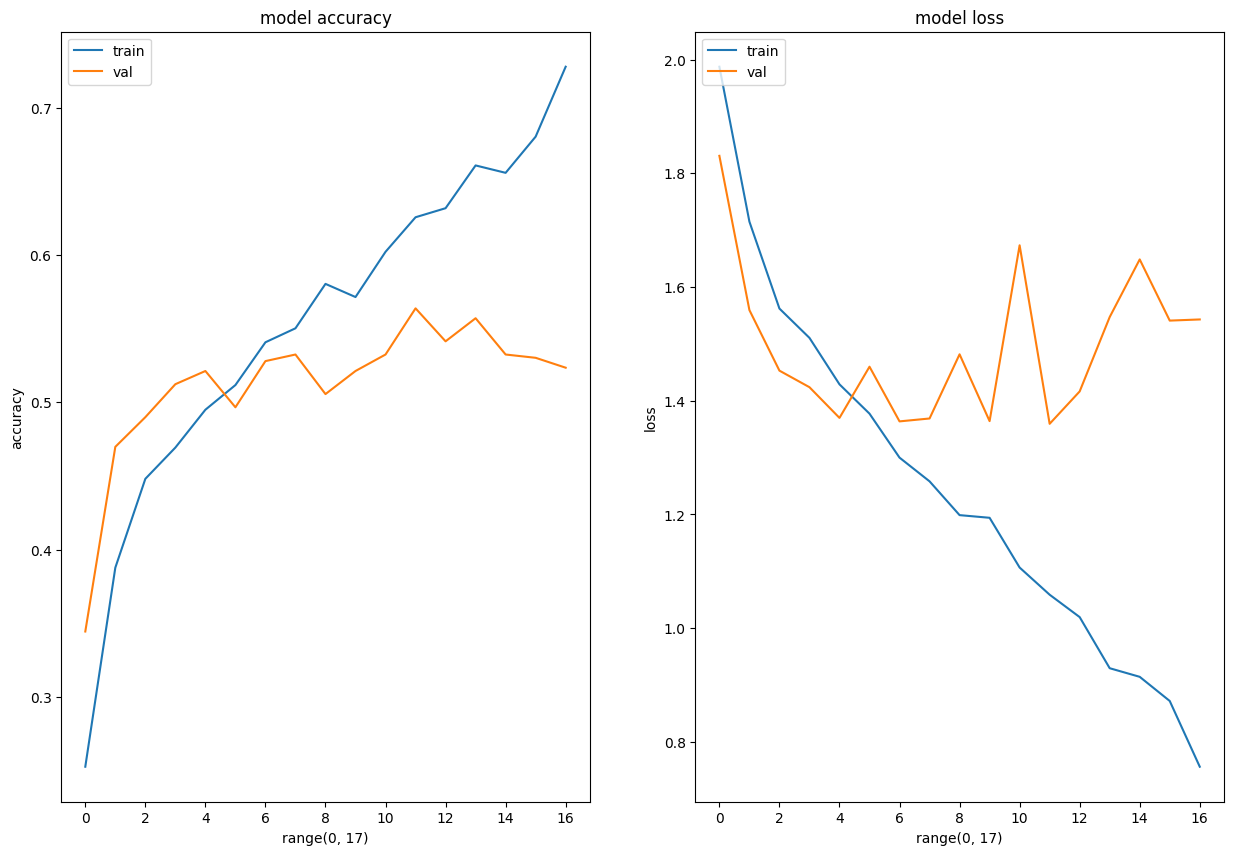

In [14]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()






In [15]:
# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.3525 - loss: 2.9027
Test Loss: 2.9187371730804443
Test Accuracy: 0.3813559412956238


#### Write your findings here

Model 1: Train accuracy 0.73, Val accuracy 0.52, and test accuracy of 0.38. This model shows overfitting

#### Model 2: Implement augmentation strategy to avoid overfitting

Create the model, compile and train the model

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Load the dataset
data_dir_train = '/content/gdrive/MyDrive/app/skin_cancer/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2
)

# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

# Apply augmentations on the images during training
def augment_images(image, label):
    image = data_augmentation(image)  # Apply augmentation
    return image, label

# Apply augmentation to the dataset
augmented_train_ds = train_ds.map(augment_images)

# Now, you can use `augmented_val_ds` for training or evaluation


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [17]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_batches = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_batches = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Create the model, compile and train the model

In [18]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#model.add(layers.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [19]:


#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


### Train the model

In [20]:

epochs = 20
#epochs=1
history = model.fit(train_batches, validation_data=valid_batches, epochs=epochs,callbacks=[checkpoint,earlystop])


Epoch 1/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1904 - loss: 2.2297
Epoch 1: val_accuracy improved from -inf to 0.27964, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.1917 - loss: 2.2242 - val_accuracy: 0.2796 - val_loss: 1.9267
Epoch 2/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2969 - loss: 1.8980
Epoch 2: val_accuracy improved from 0.27964 to 0.42729, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.2974 - loss: 1.8966 - val_accuracy: 0.4273 - val_loss: 1.6559
Epoch 3/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3838 - loss: 1.7194
Epoch 3: val_accuracy improved from 0.42729 to 0.44966, saving model to model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.3843 - loss: 1.7177 - val_accuracy: 0.4497 - val_loss: 1.5768
Epoch 4/20
55/56 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4520 - loss: 1.5708
Epoch 4: val_accuracy improved from 0.44966 to 0.47875, savin

In [21]:
# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step - accuracy: 0.3533 - loss: 3.3027
Test Loss: 2.963848829269409
Test Accuracy: 0.37288135290145874


#### Visualizing the results

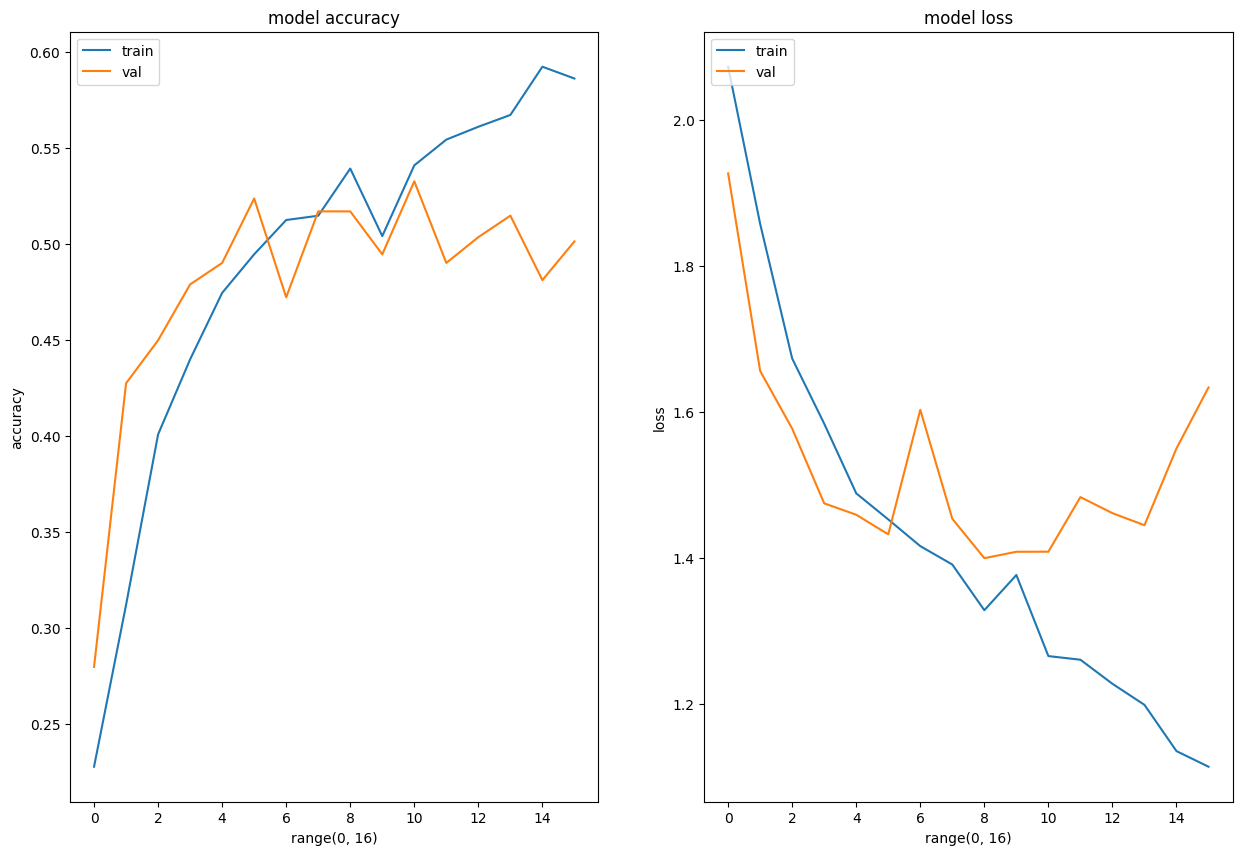

In [23]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()




#### Findings after model fit  
Model 2: Augmentation strategy

Train accuracy 0.58, validation accuracy 0.50, test accuracy 0.37

Post augmentation strategy, overfitting has reduced. Improvement observed.

#### Find the distribution of classes in the training dataset.

**Visualize distribution of classes in the training dataset.**

Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,squamous cell carcinoma,181
3,dermatofibroma,95
4,basal cell carcinoma,376
5,nevus,357
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,vascular lesion,139


<Axes: xlabel='No. of Image', ylabel='Class'>

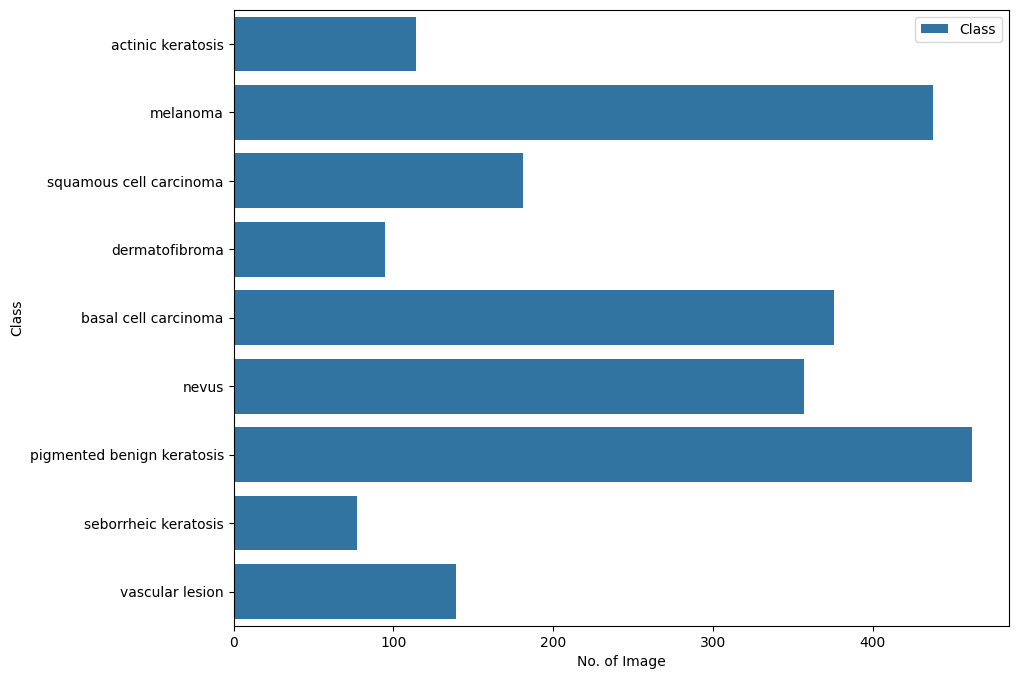

In [25]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

Write your findings here:
- Which class has the least number of samples? **seborrheic keratosis**

- Which classes dominate the data in terms proportionate number of samples? **pigmented benign keratosis**

# Rectify the class imbalance

You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
#install Augmentor
#!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2. Define a number of operations to perform on this data set using your Pipeline object.

3. Execute these operations by calling the Pipeline’s sample() method.

In [27]:
#path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
path_to_training_dataset="/content/gdrive/MyDrive/app/skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B4249C9D0>: 100%|██████████| 500/500 [00:25<00:00, 19.78 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B4249CB80>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x784B345BB2B0>: 100%|██████████| 500/500 [00:19<00:00, 25.18 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x784B4249CB80>: 100%|██████████| 500/500 [01:21<00:00,  6.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x784B440DA440>: 100%|██████████| 500/500 [01:13<00:00,  6.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784BB35EA0E0>: 100%|██████████| 500/500 [00:19<00:00, 25.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x784BC8446BF0>: 100%|██████████| 500/500 [00:41<00:00, 12.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x784B440DB6D0>: 100%|██████████| 500/500 [00:19<00:00, 25.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/app/skin_cancer/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x784C53F46CE0>: 100%|██████████| 500/500 [00:19<00:00, 25.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


Lets see the total of augmented data after adding new images to the original training data.


In [28]:
#Count total number of image generated by Augmentor.
from pathlib import Path

# Convert data_dir_train to a Path object
data_dir_train = Path('/content/gdrive/MyDrive/app/skin_cancer/Train')

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500*9 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# Model 3 with class imbalance
**Create a training dataset**

In [29]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [30]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create a validation dataset

In [31]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create your model (without normalization)

In [32]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [35]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2131 - loss: 2.0536
Epoch 1: val_accuracy improved from -inf to 0.40015, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 58s 112ms/step - accuracy: 0.2135 - loss: 2.0527 - val_accuracy: 0.4001 - val_loss: 1.6104
Epoch 2/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3901 - loss: 1.5982
Epoch 2: val_accuracy improved from 0.40015 to 0.42019, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.3903 - loss: 1.5975 - val_accuracy: 0.4202 - val_loss: 1.4843
Epoch 3/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4661 - loss: 1.4133
Epoch 3: val_accuracy improved from 0.42019 to 0.48701, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4661 - loss: 1.4133 - val_accuracy: 0.4870 - val_loss: 1.3177
Epoch 4/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5110 - loss: 1.2812
Epoch 4: val_accuracy improved from 0.48701 to 

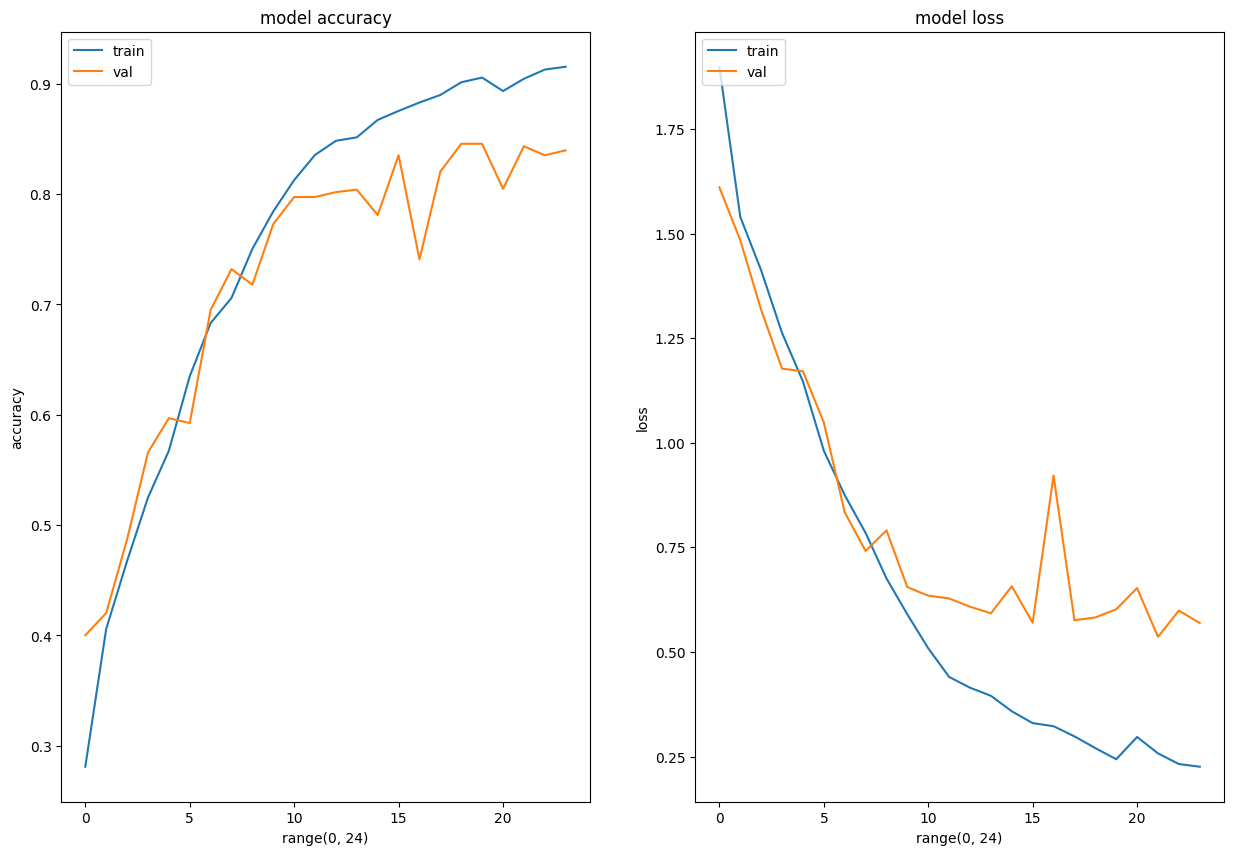

In [36]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

In [37]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3491 - loss: 4.9810
Test Loss: 5.380537033081055
Test Accuracy: 0.33898305892944336


#### Train accuracy of 0.92, validation accuracy of 0.84 and test accuracy of 0.34.


#### Model 4: Create another model Class imbalance + (make sure to include normalization)

In [38]:
#from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization

In [39]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Normalization added
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)




**Train your model**

In [41]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3082 - loss: 2.2037
Epoch 1: val_accuracy improved from -inf to 0.20341, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.3085 - loss: 2.2022 - val_accuracy: 0.2034 - val_loss: 4.4017
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4551 - loss: 1.5349
Epoch 2: val_accuracy improved from 0.20341 to 0.28434, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.4552 - loss: 1.5346 - val_accuracy: 0.2843 - val_loss: 2.4493
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4973 - loss: 1.4011
Epoch 3: val_accuracy improved from 0.28434 to 0.56644, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.4972 - loss: 1.4011 - val_accuracy: 0.5664 - val_loss: 1.1942
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5505 - loss: 1.2328
Epoch 4: val_accuracy did not improve from 0

In [42]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2317 - loss: 3.3021
Test Loss: 3.2755322456359863
Test Accuracy: 0.27966102957725525


Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings
Train accuracy: 0.78
val_accuracy: 0.53
Test accuracy 0.28

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


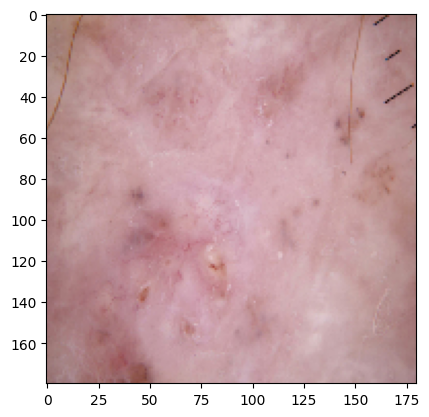

In [43]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )

# Model 5: Class imbalance + batch normalization + augmenting strategy

#### Adding augmentation to avoid overfitting

In [44]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Load the dataset
data_dir_train = '/content/gdrive/MyDrive/app/skin_cancer/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123,
    subset="training",
    validation_split=0.2
)

# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

# Apply augmentations on the images during training
def augment_images(image, label):
    image = data_augmentation(image)  # Apply augmentation
    return image, label

# Apply augmentation to the dataset
augmented_train_ds = train_ds.map(augment_images)

# Now, you can use `augmented_val_ds` for training or evaluation

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:


#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_batches = augmented_train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_batches = val_ds.cache().prefetch(buffer_size=AUTOTUNE)



Create your model

In [47]:

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.4))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(9, activation='softmax'))

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 43, 43, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       7,225,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,367,465 (28.10 MB)

 Trainable params: 7,366,761 (28.10 MB)

 Non-trainable params: 704 (2.75 KB)

Compile your model (Choose optimizer and loss function appropriately)

In [48]:


#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
try:
  checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)
except ValueError as e:
  print(f"Error creating checkpoint: {e}")
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)


Train your model

In [49]:
# Train the model
epochs = 30
#epochs=1
history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3085 - loss: 2.1723
Epoch 1: val_accuracy improved from -inf to 0.15071, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.3088 - loss: 2.1710 - val_accuracy: 0.1507 - val_loss: 12.2981
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.4264 - loss: 1.5970
Epoch 2: val_accuracy improved from 0.15071 to 0.38159, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.4263 - loss: 1.5971 - val_accuracy: 0.3816 - val_loss: 2.8226
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.4499 - loss: 1.5244
Epoch 3: val_accuracy did not improve from 0.38159
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 395ms/step - accuracy: 0.4499 - loss: 1.5245 - val_accuracy: 0.2442 - val_loss: 4.9862
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.4656 - loss: 1.4349
Epoch 4: val_accuracy did not improve from 0.38159
169/169 ━━━━━━━━━━━━

In [50]:

# test dataset
test_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123
                                                             )

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy and loss on the test dataset
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 118 files belonging to 9 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2712 - loss: 2.8071
Test Loss: 2.992279529571533
Test Accuracy: 0.27966102957725525


**Model 5 Findings**

Train acc: 0.48

Val acc: 0.32

Test acc: 0.28

Augmentation strategy doesnt work as expected with class imbalance



**Overall Findings**

**Analysis of Model Performance and Strategies**

Here's a breakdown of the different experiments and their potential implications:

**Experiment 1: No Data Augmentation, No Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.73
* **Val Acc:** 0.52
* **Test Acc:** 0.38

* **Analysis:** The model seems to be overfitting, as the validation and test accuracies are significantly lower than the training accuracy. This could be due to a lack of data diversity and the model's inability to generalize to unseen data.

**Experiment 2: Data Augmentation, No Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.58
* **Val Acc:** 0.5
* **Test Acc:** 0.37

* **Analysis:** Data augmentation seems to have helped reduce overfitting, but the overall performance is still not satisfactory. Normalization and class imbalance handling might be necessary for further improvement.

**Experiment 3: No Data Augmentation, Class Imbalance Handling, No Normalization**
* **Train Acc:** 0.92
* **Val Acc:** 0.84
* **Test Acc:** 0.34

* **Analysis:** Class imbalance handling have significantly improved the model's performance on the training and validation sets. However, the test accuracy is still low, indicating a potential overfitting issue.

**Experiment 4: No Data Augmentation, Class Imbalance Handling, Normalization**
* **Train Acc:** 0.78
* **Val Acc:** 0.53
* **Test Acc:** 0.28

* **Analysis:** This experiment adds normalization strategies, but the results are not as good as Experiment 3. This could be due to the specific data normalization techniques used or the hyperparameter settings.

**Experiment 5: Data Augmentation, Class Imbalance Handling, Normalization**

* **Train Acc:** 0.48
* **Val Acc:** 0.32
* **Test Acc:** 0.28

**Analysis:** While all three strategies were employed in this experiment, the model's performance is significantly lower than previous experiments. This could be due to several factors:



**Recommendations:**

1. **Data Augmentation:** Continue to experiment with different data augmentation techniques to improve generalization.
2. **Class Imbalance Handling:** Use techniques like oversampling, undersampling, or class weighting to address class imbalance.
3. **Normalization:** Normalize the input data to improve the model's convergence and performance.
4. **Regularization:** Use techniques like L1/L2 regularization or dropout to prevent overfitting.
5. **Hyperparameter Tuning:** Experiment with different hyperparameters like learning rate, batch size, and optimizer.
6. **Model Architecture:** Consider using more complex architectures like ResNet or EfficientNet, or explore transfer learning.
7. **Data Quality and Quantity:** Ensure that the training data is of high quality and sufficient quantity.

By carefully considering these factors and iteratively refining the model, it is possible to achieve better performance on the test set.
